# Análise Complementar (Exercício 2.4)

Neste estudo complementar, o objetivo é comparar diferentes modelos de análise de sentimentos, utilizando o mesmo pré-processamento.

O foco será avaliar o impacto de cada modelo em três datasets — com normalização, negação e lematização —, tendo em conta que o pré-processamento realizado foi mais exaustivo e direcionado, com o intuito de analisar como as diferentes abordagens influenciam os resultados finais.

Os modelos testados foram Naive Bayes (nas variações Multinomial e Bernoulli), Support Vector Machine (SVM) e Regressão Logística.


In [ ]:
# Acesso ao Google Drive
from google.colab import drive

# Manipulação de dados
import pandas as pd

# Pré-processamento de texto
import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Outros
from tqdm import tqdm
import random

# Downloads necessários do NLTK
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

# Ativar barra de progresso no pandas
tqdm.pandas()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Configurações iniciais
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
negation_words = {"not", "no", "never", "n't", "dont", "doesnt", "didnt", "isnt", "wasnt", "cannot"}
html_tags = ['i', 'b', 'em', 'br', 'hr', 'u']

# Função para aplicar negação
def handle_negation(tokens):
    result, negated = [], False
    for word in tokens:
        if word in negation_words:
            negated = True
            result.append(word)
        elif re.match(r"[.!?]", word):
            negated = False
            result.append(word)
        else:
            result.append(f"NOT_{word}" if negated else word)
    return result

# Função principal de processamento de texto
def preprocess_text(df):
    df_imdb_train = df.copy()
    df_imdb_train = df_imdb_train.drop_duplicates(keep="first")
    # Remoção de HTML
    df_imdb_train["text"] = df_imdb_train["text"].apply(lambda x: BeautifulSoup(x, "html.parser").get_text(" "))
    regex_html_tags = re.compile(r"<\s(" + "|".join(html_tags) + r")\s?>")
    df_imdb_train["text"] = df_imdb_train["text"].str.replace(regex_html_tags, " ", regex=True)
    # Remoção de links
    df_imdb_train["text"] = df_imdb_train["text"].apply(lambda x: re.sub(r"http:\s*\S+", "", x))
    df_imdb_train["text"] = df_imdb_train["text"].apply(lambda x: re.sub(r"\bwww\.\S+", "", x, flags=re.IGNORECASE))
    # Remoção de hashtags
    df_imdb_train["text"] = df_imdb_train["text"].apply(lambda x: re.sub(r"(?:^|\s)#([a-zA-Z]+)\b", " ", x))
    # Espaços extra
    df_imdb_train["text"] = df_imdb_train["text"].apply(lambda x: re.sub(r"\s+", " ", x).strip())
    # Tokenização
    df_imdb_train["text"] = df_imdb_train["text"].apply(word_tokenize)

    # Cópia para dataset com negação
    df_imdb_train_neg = df_imdb_train.copy()
    df_imdb_train_neg["text"] = df_imdb_train_neg["text"].apply(handle_negation)
    # Remoção de pontuação/números
    clean_tokens = lambda tokens: [re.sub(r"[^\sa-zA-Z]", "", w) for w in tokens if w.strip() != ""]
    df_imdb_train["text"] = df_imdb_train["text"].apply(clean_tokens)
    df_imdb_train_neg["text"] = df_imdb_train_neg["text"].apply(clean_tokens)
    # Remoção de stopwords
    remove_stops = lambda tokens: [w for w in tokens if w.lower() not in stop_words]
    df_imdb_train["text"] = df_imdb_train["text"].apply(remove_stops)
    df_imdb_train_neg["text"] = df_imdb_train_neg["text"].apply(remove_stops)
    # Conversão para texto
    df_imdb_train["text"] = df_imdb_train["text"].apply(lambda x: " ".join(x))
    df_imdb_train_neg["text"] = df_imdb_train_neg["text"].apply(lambda x: " ".join(x))

    # Cópia para dataset com lematização
    df_imdb_train_lem = df_imdb_train.copy()
    df_imdb_train_lem["text"] = df_imdb_train_lem["text"].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

    return df_imdb_train, df_imdb_train_neg, df_imdb_train_lem

# Função para avaliar o modelo
def avaliar_modelo(y_true, y_pred, nome_modelo):
    print(f"\nResultados para: {nome_modelo}")

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {round(accuracy, 3)}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4, target_names = ['Negativo', 'Positivo']))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de Confusão - {nome_modelo}')
    plt.show()

In [ ]:
# Carregar dados brutos
df_imdb_train_raw = pd.read_csv("imdb_reviews_train.csv")
df_imdb_test_raw = pd.read_csv("imdb_reviews_test.csv")

# Aplicar o processamento (mantendo os nomes desejados)
df_imdb_train, df_imdb_train_neg, df_imdb_train_lem = preprocess_text(df_imdb_train_raw)
df_imdb_test, df_imdb_test_neg, df_imdb_test_lem = preprocess_text(df_imdb_test_raw)

# Feature Extraction

## TF-IDF

In [ ]:
# Função para aplicar TF-IDF e retornar os vetores transformados
def aplicar_tfidf(df_treino, df_teste, coluna_texto, max_features=10000, min_df=10, ngram_range=(1,3), sublinear_tf=True):
    vetorizador = TfidfVectorizer(
        max_features=max_features,
        min_df=min_df,
        ngram_range=ngram_range,
        sublinear_tf=sublinear_tf
    )
    X_train = vetorizador.fit_transform(df_treino[coluna_texto])
    X_test = vetorizador.transform(df_teste[coluna_texto])
    return X_train, X_test, vetorizador


In [ ]:
# TF-IDF para os três textos
X_train_tfidf, X_test_tfidf, tfidf_vectorizer = aplicar_tfidf(df_imdb_train, df_imdb_test, "text")
X_train_tfidf_neg, X_test_tfidf_neg, tfidf_vectorizer_neg = aplicar_tfidf(df_imdb_train_neg, df_imdb_test_neg, "text")
X_train_tfidf_lem, X_test_tfidf_lem, tfidf_vectorizer_lem = aplicar_tfidf(df_imdb_train_lem, df_imdb_test_lem, "text")

In [ ]:
# Ver as primeiras 20 palavras mais importantes (sem, e após spell correction):
print("Sem Lematização nem Negação\n")
print(tfidf_vectorizer.get_feature_names_out()[:20])
print("\nAplicando Negação\n")
print(tfidf_vectorizer_neg.get_feature_names_out()[:20])
print("\Aplicando Lematização\n")
print(tfidf_vectorizer_lem.get_feature_names_out()[:20])

Sem Lematização nem Negação

['abandoned' 'abc' 'abilities' 'ability' 'able' 'able get' 'able see'
 'abomination' 'abortion' 'abound' 'abraham' 'abrupt' 'abruptly' 'absence'
 'absent' 'absolute' 'absolutely' 'absolutely hilarious'
 'absolutely loved' 'absolutely nothing']

Aplicando Negação

['abandoned' 'abc' 'abilities' 'ability' 'able' 'abraham' 'abruptly'
 'absence' 'absent' 'absolute' 'absolutely' 'absolutely loved'
 'absolutely nothing' 'absorbed' 'absurd' 'absurdity' 'abuse' 'abused'
 'abusive' 'abysmal']
\Aplicando Lematização

['abandon' 'abandoned' 'abc' 'ability' 'able' 'able get' 'able see'
 'abomination' 'abortion' 'abound' 'abraham' 'abrupt' 'abruptly' 'absence'
 'absent' 'absolute' 'absolutely' 'absolutely hilarious'
 'absolutely loved' 'absolutely nothing']


# Modeling

Embora o artigo de referência utilizado neste trabalho (Danyal et al., 2024) tenha explorado apenas modelos de Naive Bayes, optámos por alargar a análise a outros modelos que também são referidos na literatura do próprio artigo como promissores. Assim, incluímos modelos adicionais que considerámos relevantes para o nosso estudo comparativo.

Todos os modelos foram testados sobre os três tipos de texto preparados: texto normal, texto com tratamento de negação e texto lematizado.


In [ ]:
# Função principal para o treino e avaliação dos modelos
def treinar_avaliar_modelo(modelo_base, X_train, X_test, df_train, df_test, nome_modelo="Modelo"):
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import LabelEncoder
    from sklearn.metrics import accuracy_score
    import pandas as pd
    from sklearn.naive_bayes import MultinomialNB, BernoulliNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import LinearSVC

    # Transformar labels em números
    codificador = LabelEncoder()
    y_train = codificador.fit_transform(df_train["label"])
    y_test = codificador.transform(df_test["label"])

    # Definir os parâmetros a testar conforme o modelo
    if isinstance(modelo_base, MultinomialNB): param_grid = {"alpha": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0], "fit_prior": [True, False]}
    elif isinstance(modelo_base, BernoulliNB): param_grid = {"alpha": [0.001, 0.01, 0.1, 0.5, 1.0], "fit_prior": [True, False], "binarize": [0.0, 0.1, 0.3, 0.5]}
    elif isinstance(modelo_base, LogisticRegression): param_grid = {"C": [0.01, 0.1, 1, 5, 10], "penalty": ["l2"], "solver": ["lbfgs"], "max_iter": [1000]}
    elif isinstance(modelo_base, LinearSVC): param_grid = {"C": [0.01, 0.1, 1, 5, 10], "max_iter": [1000]}

    # Grid Search com validação cruzada
    grid = GridSearchCV(modelo_base, param_grid, cv=10, scoring="accuracy", n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    melhor_modelo = grid.best_estimator_

    # Previsões
    y_pred = melhor_modelo.predict(X_test)
    y_pred_train = melhor_modelo.predict(X_train)

    # Accuracy no treino e teste
    acc_test = accuracy_score(y_test, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)

    # Mostrar resultados principais
    print(f"\nResultados para: {nome_modelo}")
    print(f"Melhores parâmetros: {grid.best_params_}")
    print(f"Accuracy no teste: {acc_test:.4f}")
    print(f"Accuracy no treino: {acc_train:.4f}")
    print(f"Diferença (treino - teste): {acc_train - acc_test:.4f}")

    # Avaliação final com métricas e matriz
    avaliar_modelo(y_test, y_pred, nome_modelo)

## Modelos com Naive Bayes

Para os modelos de NB, e como sugerido no artigo, foi feita a busca dos melhores parâmetros com recurso a grid search. Os parâmetros dos modelos de Naive Bayes incluem o parâmetro de suavidade (*alpha*), e o indicador booleano (*fit_prior*). Foram testadas duas variantes do Naive Bayes: Multinomial e Bernoulli, aplicadas aos três tipos de texto (normal, com negação e lematizado).

### Multinomial Naive Bayes

Fitting 10 folds for each of 14 candidates, totalling 140 fits

Resultados para: Multinomial NB - Normal
Melhores parâmetros: {'alpha': 0.1, 'fit_prior': True}
Accuracy no teste: 0.8639
Accuracy no treino: 0.8956
Diferença (treino - teste): 0.0317

Resultados para: Multinomial NB - Normal
Accuracy: 0.864

Classification Report:
              precision    recall  f1-score   support

    Negativo     0.8614    0.8679    0.8646     10926
    Positivo     0.8665    0.8598    0.8631     10888

    accuracy                         0.8639     21814
   macro avg     0.8639    0.8639    0.8639     21814
weighted avg     0.8639    0.8639    0.8639     21814



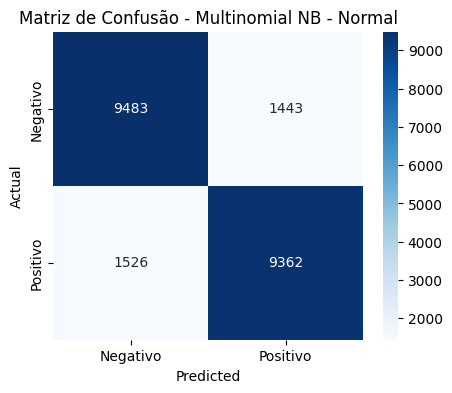

In [ ]:
# MultinomialNB
treinar_avaliar_modelo(MultinomialNB(), X_train_tfidf, X_test_tfidf, df_imdb_train, df_imdb_test, "Multinomial NB - Normal")

Fitting 10 folds for each of 14 candidates, totalling 140 fits

Resultados para: Multinomial NB - Negação
Melhores parâmetros: {'alpha': 0.1, 'fit_prior': False}
Accuracy no teste: 0.8514
Accuracy no treino: 0.8803
Diferença (treino - teste): 0.0289

Resultados para: Multinomial NB - Negação
Accuracy: 0.851

Classification Report:
              precision    recall  f1-score   support

    Negativo     0.8468    0.8586    0.8527     10926
    Positivo     0.8561    0.8441    0.8501     10888

    accuracy                         0.8514     21814
   macro avg     0.8515    0.8514    0.8514     21814
weighted avg     0.8514    0.8514    0.8514     21814



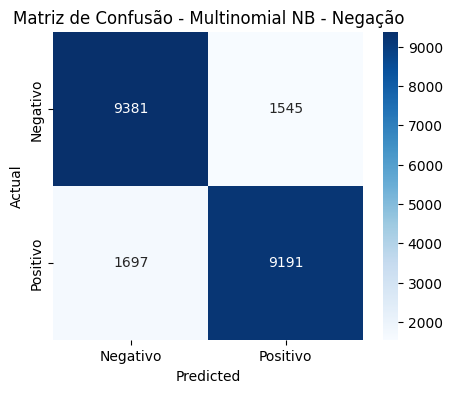

In [ ]:
# MultinomialNB
treinar_avaliar_modelo(MultinomialNB(), X_train_tfidf_neg, X_test_tfidf_neg, df_imdb_train_neg, df_imdb_test_neg, "Multinomial NB - Negação")

Fitting 10 folds for each of 14 candidates, totalling 140 fits

Resultados para: Multinomial NB - Lem
Melhores parâmetros: {'alpha': 0.1, 'fit_prior': True}
Accuracy no teste: 0.8623
Accuracy no treino: 0.8947
Diferença (treino - teste): 0.0323

Resultados para: Multinomial NB - Lem
Accuracy: 0.862

Classification Report:
              precision    recall  f1-score   support

    Negativo     0.8596    0.8666    0.8631     10926
    Positivo     0.8651    0.8580    0.8615     10888

    accuracy                         0.8623     21814
   macro avg     0.8624    0.8623    0.8623     21814
weighted avg     0.8624    0.8623    0.8623     21814



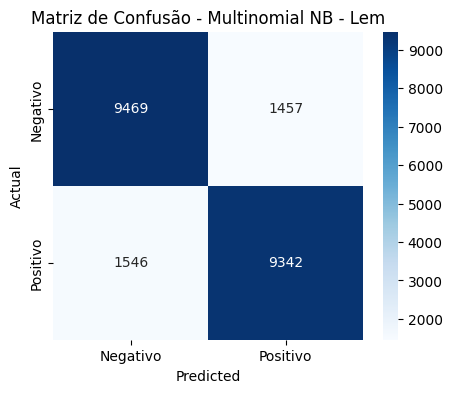

In [ ]:
# Multinomial Naive Bayes aplicado ao texto lematizado
treinar_avaliar_modelo(MultinomialNB(), X_train_tfidf_lem, X_test_tfidf_lem, df_imdb_train_lem, df_imdb_test_lem, "Multinomial NB - Lem")

### Bernoulli Naive Bayes

Fitting 10 folds for each of 40 candidates, totalling 400 fits

Resultados para: Bernoulli NB - Normal
Melhores parâmetros: {'alpha': 0.1, 'binarize': 0.0, 'fit_prior': True}
Accuracy no teste: 0.8667
Accuracy no treino: 0.8888
Diferença (treino - teste): 0.0221

Resultados para: Bernoulli NB - Normal
Accuracy: 0.867

Classification Report:
              precision    recall  f1-score   support

    Negativo     0.8770    0.8537    0.8652     10926
    Positivo     0.8570    0.8799    0.8683     10888

    accuracy                         0.8667     21814
   macro avg     0.8670    0.8668    0.8667     21814
weighted avg     0.8670    0.8667    0.8667     21814



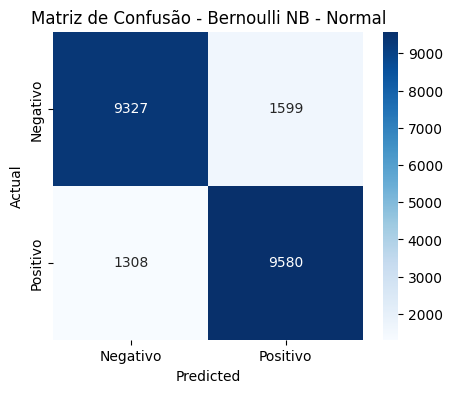

In [ ]:
# Bernoulli Naive Bayes com vetorização TF-IDF sobre o texto original
treinar_avaliar_modelo(BernoulliNB(), X_train_tfidf, X_test_tfidf, df_imdb_train, df_imdb_test, "Bernoulli NB - Normal")

Fitting 10 folds for each of 40 candidates, totalling 400 fits

Resultados para: Bernoulli NB - Negação
Melhores parâmetros: {'alpha': 0.01, 'binarize': 0.1, 'fit_prior': True}
Accuracy no teste: 0.8354
Accuracy no treino: 0.8743
Diferença (treino - teste): 0.0389

Resultados para: Bernoulli NB - Negação
Accuracy: 0.835

Classification Report:
              precision    recall  f1-score   support

    Negativo     0.8388    0.8312    0.8350     10926
    Positivo     0.8322    0.8396    0.8359     10888

    accuracy                         0.8354     21814
   macro avg     0.8355    0.8354    0.8354     21814
weighted avg     0.8355    0.8354    0.8354     21814



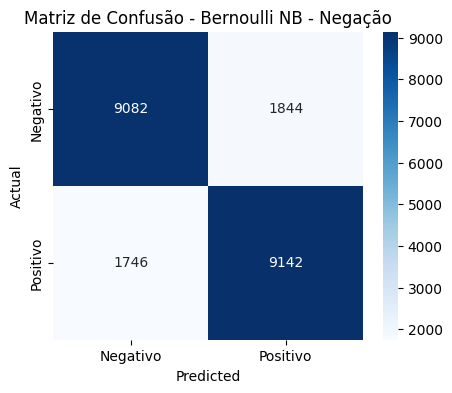

In [ ]:
# Bernoulli Naive Bayes com negação tratada
treinar_avaliar_modelo(BernoulliNB(), X_train_tfidf_neg, X_test_tfidf_neg, df_imdb_train_neg, df_imdb_test_neg, "Bernoulli NB - Negação")

Fitting 10 folds for each of 40 candidates, totalling 400 fits

Resultados para: Bernoulli NB - Lem
Melhores parâmetros: {'alpha': 1.0, 'binarize': 0.0, 'fit_prior': True}
Accuracy no teste: 0.8642
Accuracy no treino: 0.8883
Diferença (treino - teste): 0.0241

Resultados para: Bernoulli NB - Lem
Accuracy: 0.864

Classification Report:
              precision    recall  f1-score   support

    Negativo     0.8736    0.8522    0.8628     10926
    Positivo     0.8552    0.8763    0.8656     10888

    accuracy                         0.8642     21814
   macro avg     0.8644    0.8642    0.8642     21814
weighted avg     0.8644    0.8642    0.8642     21814



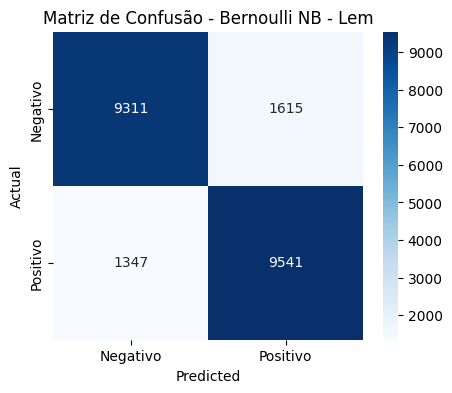

In [ ]:
# Bernoulli Naive Bayes sobre o texto lematizado
treinar_avaliar_modelo(BernoulliNB(), X_train_tfidf_lem, X_test_tfidf_lem, df_imdb_train_lem, df_imdb_test_lem, "Bernoulli NB - Lem")

Conclusão: Os resultados obtidos são superiores aos do artigo de referência, o que provavelmente ve-se ao facto de termos feito um pré-processamento mais específico. FALAR DO MELHOR MODELO DE CADA SUBTOPIC

**Conclusão**:

- Os resultados obtidos foram ligeiramente superiores aos mencionados no artigo, o que pode dever-se a diferenças nos dados ou nas etapas de pré-processamento aplicadas.
- Os modelos Multinomial apresentaram desempenhos bastante consistentes entre si, com diferenças pequenas entre treino e teste, indicando ausência de overfitting.
- Os modelos Bernoulli mostraram também boa estabilidade, mas no caso com negação, a diferença entre treino e teste foi um pouco maior, o que pode indicar ligeira perda de generalização.
- O modelo com melhor desempenho foi o **Bernoulli NB com texto normal**, atingindo uma *accuracy* de 0.8667 no teste.
- No geral, os modelos Bernoulli NB apresentaram ligeiramente melhores resultados que os Multinomial NB, especialmente no texto normal e lematizado.



## Modelos com Regressão Logística

Na Regressão Logística, foi feita uma grid search para encontrar o melhor valor do parâmetro *C*, responsável pela regularização. Foram ainda definidos os valores para *penalty*, *solver* e *max_iter*, garantindo consistência no treino do modelo.


Fitting 10 folds for each of 5 candidates, totalling 50 fits

Resultados para: LogReg - Normal
Melhores parâmetros: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy no teste: 0.8901
Accuracy no treino: 0.9318
Diferença (treino - teste): 0.0417

Resultados para: LogReg - Normal
Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

    Negativo     0.8919    0.8882    0.8900     10926
    Positivo     0.8882    0.8920    0.8901     10888

    accuracy                         0.8901     21814
   macro avg     0.8901    0.8901    0.8901     21814
weighted avg     0.8901    0.8901    0.8901     21814



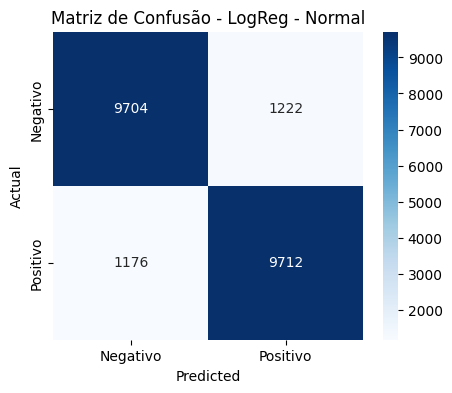

In [ ]:
# Regressão Logística sobre o texto original
treinar_avaliar_modelo(LogisticRegression(random_state=42), X_train_tfidf, X_test_tfidf, df_imdb_train, df_imdb_test, "LogReg - Normal")

Fitting 10 folds for each of 5 candidates, totalling 50 fits

Resultados para: LogReg - Negação
Melhores parâmetros: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy no teste: 0.8916
Accuracy no treino: 0.9302
Diferença (treino - teste): 0.0386

Resultados para: LogReg - Negação
Accuracy: 0.892

Classification Report:
              precision    recall  f1-score   support

    Negativo     0.8910    0.8928    0.8919     10926
    Positivo     0.8922    0.8904    0.8913     10888

    accuracy                         0.8916     21814
   macro avg     0.8916    0.8916    0.8916     21814
weighted avg     0.8916    0.8916    0.8916     21814



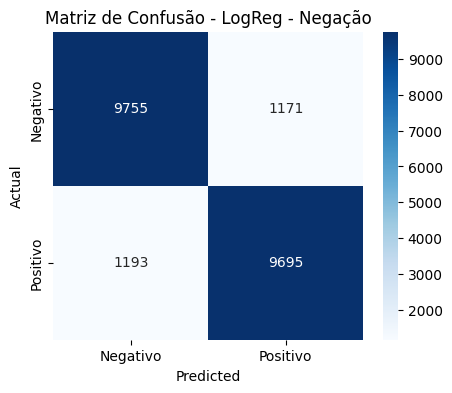

In [ ]:
# Regressão Logística com tratamento de negação
treinar_avaliar_modelo(LogisticRegression(random_state=42), X_train_tfidf_neg, X_test_tfidf_neg, df_imdb_train_neg, df_imdb_test_neg, "LogReg - Negação")

Fitting 10 folds for each of 5 candidates, totalling 50 fits

Resultados para: LogReg - Lem
Melhores parâmetros: {'C': 5, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy no teste: 0.8832
Accuracy no treino: 0.9651
Diferença (treino - teste): 0.0819

Resultados para: LogReg - Lem
Accuracy: 0.883

Classification Report:
              precision    recall  f1-score   support

    Negativo     0.8826    0.8845    0.8835     10926
    Positivo     0.8838    0.8819    0.8829     10888

    accuracy                         0.8832     21814
   macro avg     0.8832    0.8832    0.8832     21814
weighted avg     0.8832    0.8832    0.8832     21814



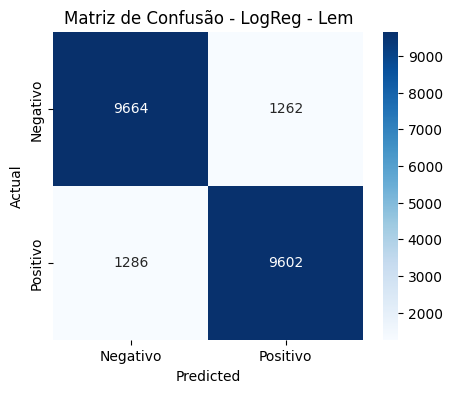

In [ ]:
# Regressão Logística com texto lematizado
treinar_avaliar_modelo(LogisticRegression(random_state=42), X_train_tfidf_lem, X_test_tfidf_lem, df_imdb_train_lem, df_imdb_test_lem, "LogReg - Lem")

**Conclusão**:

- Os três modelos de Regressão Logística apresentaram desempenhos semelhantes, com valores de *accuracy* no teste bastante próximos.
- Os modelos **normal e com negação** mostram-se equilibrados, sem sinais claros de *overfitting*, dado que a diferença entre treino e teste é reduzida. No entanto o modelo **lematizado** teve uma *accuracy* de treino bastante mais alta (0.9651), o que indica sinais de **overfitting** nesse caso.
- Os parâmetros escolhidos variaram ligeiramente: *C=1* para os modelos normal e com negação, e *C=5* para o modelo lematizado, indicando menor regularização no último.
- O modelo com melhor desempenho foi o que inclui tratamento de negação, com uma accuracy no teste de 0.8916.


## Modelos com SVM

No modelo SVM, foi utilizado grid search para testar diferentes valores do parâmetro *C*, que controla o nível de regularização do modelo. Também foi ajustado o número máximo de iterações (*max_iter*) para garantir a convergência durante o treino.


Fitting 10 folds for each of 5 candidates, totalling 50 fits

Resultados para: SVM - Normal
Melhores parâmetros: {'C': 0.1, 'max_iter': 1000}
Accuracy no teste: 0.8914
Accuracy no treino: 0.9346
Diferença (treino - teste): 0.0433

Resultados para: SVM - Normal
Accuracy: 0.891

Classification Report:
              precision    recall  f1-score   support

    Negativo     0.8940    0.8884    0.8912     10926
    Positivo     0.8887    0.8943    0.8915     10888

    accuracy                         0.8914     21814
   macro avg     0.8914    0.8914    0.8914     21814
weighted avg     0.8914    0.8914    0.8914     21814



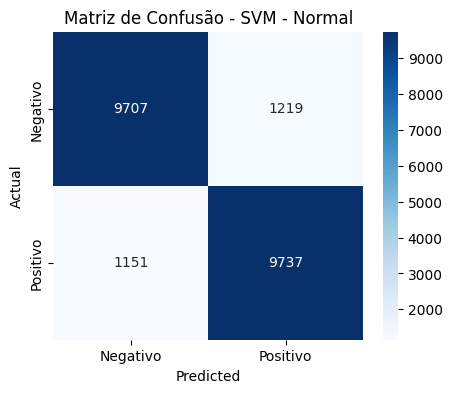

In [ ]:
# SVM Linear com texto original
treinar_avaliar_modelo(LinearSVC(random_state=42), X_train_tfidf, X_test_tfidf, df_imdb_train, df_imdb_test, "SVM - Normal")

Fitting 10 folds for each of 5 candidates, totalling 50 fits

Resultados para: SVM - Negação
Melhores parâmetros: {'C': 0.1, 'max_iter': 1000}
Accuracy no teste: 0.8931
Accuracy no treino: 0.9323
Diferença (treino - teste): 0.0392

Resultados para: SVM - Negação
Accuracy: 0.893

Classification Report:
              precision    recall  f1-score   support

    Negativo     0.8937    0.8927    0.8932     10926
    Positivo     0.8925    0.8935    0.8930     10888

    accuracy                         0.8931     21814
   macro avg     0.8931    0.8931    0.8931     21814
weighted avg     0.8931    0.8931    0.8931     21814



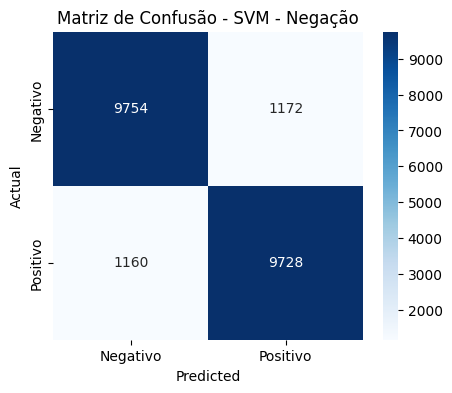

In [ ]:
# SVM Linear com tokens com negação
treinar_avaliar_modelo(LinearSVC(random_state=42), X_train_tfidf_neg, X_test_tfidf_neg, df_imdb_train_neg, df_imdb_test_neg, "SVM - Negação")

Fitting 10 folds for each of 5 candidates, totalling 50 fits

Resultados para: SVM - Lem
Melhores parâmetros: {'C': 0.1, 'max_iter': 1000}
Accuracy no teste: 0.8896
Accuracy no treino: 0.9334
Diferença (treino - teste): 0.0439

Resultados para: SVM - Lem
Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

    Negativo     0.8929    0.8858    0.8893     10926
    Positivo     0.8863    0.8934    0.8898     10888

    accuracy                         0.8896     21814
   macro avg     0.8896    0.8896    0.8896     21814
weighted avg     0.8896    0.8896    0.8896     21814



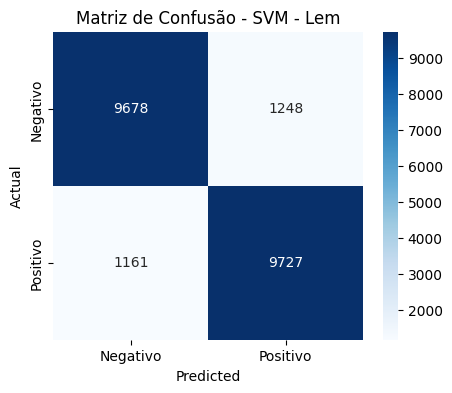

In [ ]:
# SVM Linear com texto lematizado
treinar_avaliar_modelo(LinearSVC(random_state=42), X_train_tfidf_lem, X_test_tfidf_lem, df_imdb_train_lem, df_imdb_test_lem, "SVM - Lem")

**Conclusão**:

- Os três modelos de SVM (normal, com negação e lematizado) apresentam resultados bastante consistentes. As diferenças entre os valores de *accuracy* no treino e no teste são pequenas, o que indica que os modelos **não estão overfitted**.
- O parâmetro *C* escolhido em todos os casos foi 0.1, o que mostra que uma regularização mais forte trouxe bons resultados.
- O modelo com melhor desempenho foi o SVM com tratamento de **negação**, com uma accuracy no teste de 0.8931.
- No geral, os resultados mostram que o SVM se adapta bem a diferentes versões do texto, mantendo um bom equilíbrio entre treino e teste.



#Considerações Finais

Os dois melhores resultados foram obtidos com os modelos SVM e Regressão Logística, ambos aplicados ao texto com tratamento de negação. Apesar do SVM ter apresentado uma ligeira vantagem em termos de accuracy (89,3% contra 89,2%), a diferença é muito pequena e pode ser considerada irrelevante na prática. Isto mostra que ambos os modelos são robustos e beneficiaram de forma semelhante do mesmo tipo de pré-processamento.


# Referências Bibliográficas

Danyal, M. M., Khan, S. S., Khan, M., Ullah, S., Ghaffar, M. B., & Khan, W. (2024). Sentiment analysis of movie reviews based on NB approaches using TF–IDF and count vectorizer. Social Network Analysis and Mining, 14(87).